In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

In [2]:
class_train = pd.read_csv("train_3.csv")
class_test = pd.read_csv("test_3.csv")
regression_train = pd.read_csv("train_4.csv")
regression_test = pd.read_csv("test_4.csv")
ids_class = class_test['id']
ids_reg = regression_test['id']

# Предварительная обработка

### Классификация

In [4]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


### Регрессия

In [5]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

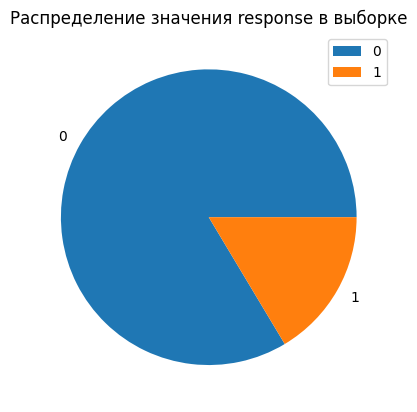

In [6]:
plt.pie(class_train[class_result].value_counts(), labels=(0, 1))
plt.title("Распределение значения response в выборке")
plt.legend((0, 1))
plt.show()

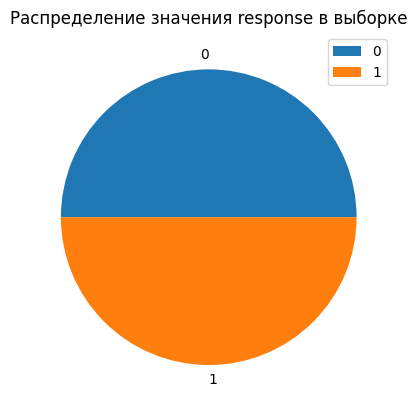

In [7]:
x = class_train[class_all]
y = class_train[class_result]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
plt.pie(y.value_counts(), labels=(0, 1))
plt.title("Распределение значения response в выборке")
plt.legend((0, 1))
plt.show()

In [8]:

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size=0.3, random_state=7)

In [9]:
def compare_parameters(parameters, test_scores, train_scores, is_regression=False):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  
    fig.subplots_adjust(hspace=0.4)
    id = 0
    for key in test_scores.keys():
        if key != "criterion":
            plot_accuracy_graph(parameters[key], key, axs[id], train_scores[key], test_scores[key],
                                 regression=is_regression)
        else:
            plot_criteria(parameters[key], axs[id], train_scores[key], test_scores[key], regression=is_regression)
        id += 1

def create_best_model(params, is_regression=False):
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    model = model_class(**params)
    model.fit(x_train_reg if is_regression else x_train_class,
              y_train_reg if is_regression else y_train_class)
    score = model.score(x_test_reg if is_regression else x_test_class,
                        y_test_reg if is_regression else y_test_class)
    print(f"Model: {model}\nScore: {round(score, 3)}")
    return model, score

def build_grid(params, x_train, y_train, x_test, y_test, is_regression):
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    scoring = 'neg_mean_squared_error' if is_regression else 'roc_auc'
    grid = GridSearchCV(model_class(), params, scoring=scoring)
    grid.fit(x_train, y_train)
    score = grid.best_score_ if not is_regression else r2_score(y_test, grid.predict(x_test))
    print(f"The best model: {grid.best_estimator_}\nAccuracy: {round(score, 3)}")
    return grid.cv_results_["mean_test_score"], grid.best_params_

def test_parameters(parameters, train_acc, test_acc, cross_val_acc,  x_train, y_train, x_test, y_test, is_regression=False):
    parameter_name = next(iter(parameters.keys()))
    train_acc[parameter_name] = []
    test_acc[parameter_name] = []
    for parameter in parameters[parameter_name]:
        value = {parameter_name: parameter}
        if is_regression:
            clf = DecisionTreeRegressor(**value)
        else:
            clf = DecisionTreeClassifier(**value)
        clf.fit(x_train, y_train)
        if not is_regression: 
            y_pred_train = clf.predict(x_train)
            y_pred_test = clf.predict(x_test) 
            train_acc[parameter_name].append(accuracy_score(y_train, y_pred_train))
            test_acc[parameter_name].append(accuracy_score(y_test, y_pred_test))
        else:
            train_acc[parameter_name].append(clf.score(x_train, y_train))
            test_acc[parameter_name].append(clf.score(x_test, y_test))
    cross_val, best_param = build_grid(parameters, x_train, y_train, x_test, y_test, is_regression)
    cross_val_acc[parameter_name] = cross_val
    return best_param[parameter_name]

def plot_criteria(parameters, ax, train_acc, test_acc, regression=False):
    ax.bar(parameters, train_acc, label="train")
    ax.bar(parameters, test_acc, label="test")
    ax.legend()
    ax.set_xlabel("criteria", labelpad=15)
    ax.set_title(f"Accuracy vs criteria" if not regression else f"R^2 vs criteria")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)

def plot_accuracy_graph(parameters, parameter_name, ax, train_acc, test_acc, regression=False):
    ax.plot(parameters, train_acc, label="Train")
    ax.plot(parameters, test_acc, label="Test")
    ax.set_xlabel(parameter_name, labelpad=15)
    ax.set_title(f"Accuracy vs {parameter_name}" if not regression else f"R^2 vs {parameter_name}")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)
    ax.legend()


классификация

In [10]:
train_acc = {}
test_acc = {}
cross_val_acc = {}

In [11]:
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15)
}
best_parameters_сlass = dict()

In [12]:
best_parameters_сlass["criterion"] = test_parameters({"criterion": params["criterion"]}, train_acc, test_acc, cross_val_acc,  x_train_class, y_train_class, x_test_class, y_test_class)
best_parameters_сlass["max_leaf_nodes"] = test_parameters({"max_leaf_nodes": params["max_leaf_nodes"]}, train_acc, test_acc, cross_val_acc, 
                                                    x_train_class, y_train_class, x_test_class, y_test_class)
best_parameters_сlass["max_depth"] = test_parameters({"max_depth": params["max_depth"]}, train_acc, test_acc, cross_val_acc, 
                                               x_train_class, y_train_class, x_test_class, y_test_class)

The best model: DecisionTreeClassifier(criterion='entropy')
Accuracy: 0.887
The best model: DecisionTreeClassifier(max_leaf_nodes=38)
Accuracy: 0.949
The best model: DecisionTreeClassifier(max_depth=11)
Accuracy: 0.95


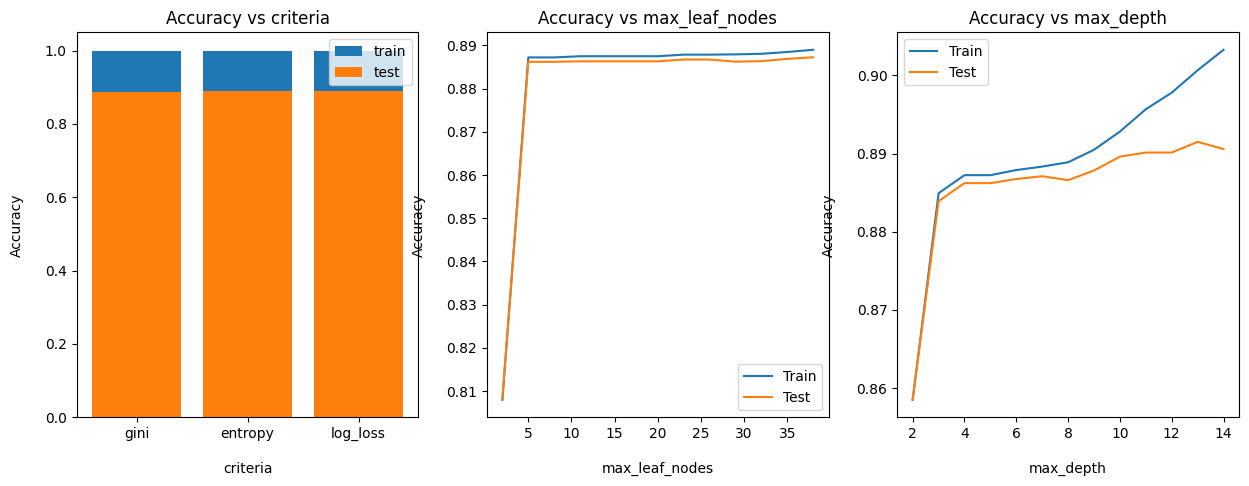

In [13]:
compare_parameters(params, test_acc, train_acc)  

Model: DecisionTreeClassifier(criterion='entropy', max_depth=11, max_leaf_nodes=38)
Score: 0.886
Файл submission_class.csv сохранен.


[Text(0.523828125, 0.9583333333333334, 'Vehicle_Damage <= 0.5\nentropy = 1.0\nsamples = 268338\nvalue = [134087, 134251]'),
 Text(0.3921875, 0.875, 'Previously_Insured <= 0.5\nentropy = 0.038\nsamples = 83224\nvalue = [82889, 335]'),
 Text(0.4580078125, 0.9166666666666667, 'True  '),
 Text(0.3671875, 0.7916666666666666, 'entropy = 0.23\nsamples = 8308\nvalue = [7997, 311]'),
 Text(0.4171875, 0.7916666666666666, 'entropy = 0.004\nsamples = 74916\nvalue = [74892, 24]'),
 Text(0.65546875, 0.875, 'Gender <= 0.5\nentropy = 0.851\nsamples = 185114\nvalue = [51198, 133916]'),
 Text(0.5896484375, 0.9166666666666667, '  False'),
 Text(0.4671875, 0.7916666666666666, 'Vehicle_Age <= 0.5\nentropy = 0.623\nsamples = 139658\nvalue = [21688, 117970]'),
 Text(0.334375, 0.7083333333333334, 'Age <= 0.6\nentropy = 0.459\nsamples = 128210\nvalue = [12419, 115791]'),
 Text(0.21875, 0.625, 'Previously_Insured <= 0.5\nentropy = 0.403\nsamples = 118302\nvalue = [9489, 108813]'),
 Text(0.19375, 0.5416666666666

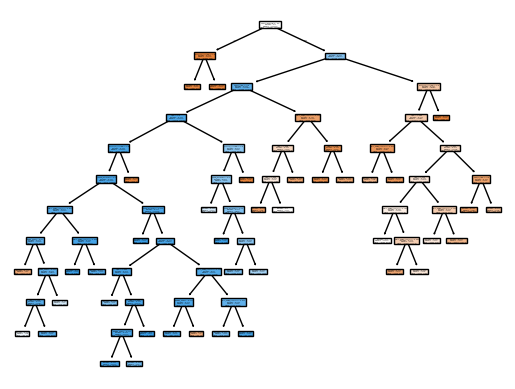

In [14]:
model, class_score = create_best_model(best_parameters_сlass)
class_test = class_test[class_all]
y_pred = model.predict(class_test)
submission_class = pd.DataFrame({'id': ids_class, 'Response': y_pred})

submission_class.to_csv('submission_class.csv', index=False)
print("Файл submission_class.csv сохранен.")

tree.plot_tree(model, filled=True, feature_names=list(x_test_class.columns))

регрессия

In [15]:
train_acc = {}
test_acc = {}
cross_val_acc = {}
best_parameters_reg = dict()
params = {
    "criterion": ["poisson", "friedman_mse", "absolute_error", "squared_error"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15)
}   

In [16]:

best_parameters_reg["criterion"] = test_parameters({"criterion": params["criterion"]}, train_acc, test_acc, cross_val_acc, 
                                               x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)
best_parameters_reg["max_leaf_nodes"] = test_parameters({"max_leaf_nodes": params["max_leaf_nodes"]}, train_acc, test_acc, cross_val_acc, 
                                                    x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)
best_parameters_reg["max_depth"] = test_parameters({"max_depth": params["max_depth"]}, train_acc, test_acc, cross_val_acc, 
                                               x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)

The best model: DecisionTreeRegressor(criterion='friedman_mse')
Accuracy: 0.808
The best model: DecisionTreeRegressor(max_leaf_nodes=17)
Accuracy: 0.845
The best model: DecisionTreeRegressor(max_depth=4)
Accuracy: 0.844


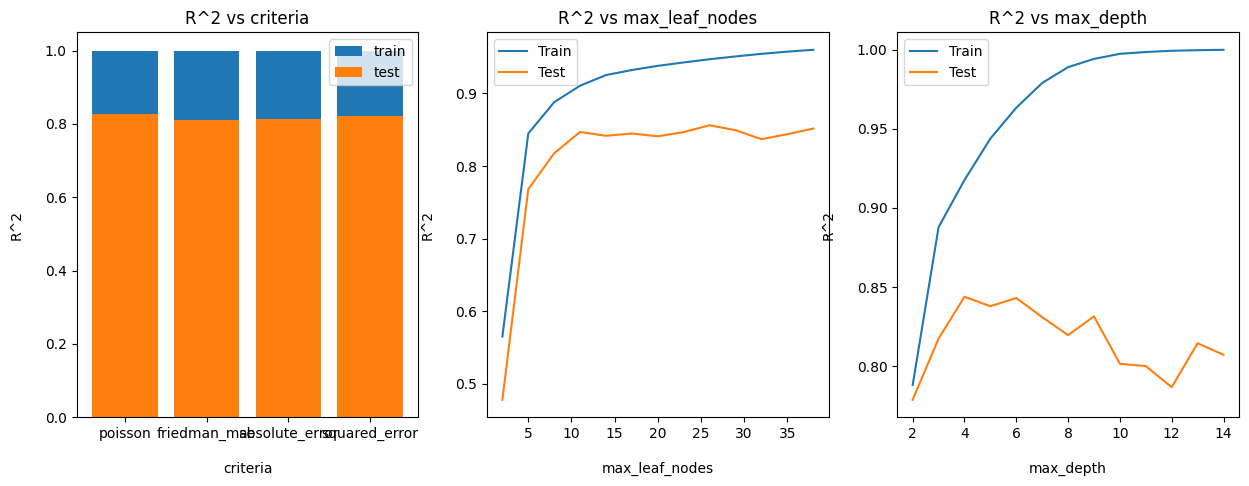

In [17]:
compare_parameters(params, test_acc, train_acc, is_regression=True) 

In [18]:
print(regression_test)

     Количество.комнат  Студия  Общая.площадь      Этаж  Этажей.в.доме  \
0                    1       0       0.204545  0.125000           0.56   
1                    1       0       0.172727  0.000000           0.00   
2                    1       0       0.194697  0.041667           0.60   
3                    4       0       0.541667  0.375000           0.32   
4                    1       0       0.227273  0.375000           0.32   
..                 ...     ...            ...       ...            ...   
778                  2       0       0.272727  0.166667           0.12   
779                  4       0       0.545455  0.375000           0.32   
780                  1       0       0.181818  0.291667           0.32   
781                  2       0       0.310606  0.083333           0.12   
782                  2       0       0.289394  0.000000           0.08   

     Парковка  Без.ремонта  Дизайнерский  Евроремонт  Косметический  ...  \
0           0            0         

In [19]:
print(regression_train)

     Количество.комнат  Студия  Общая.площадь      Этаж  Этажей.в.доме  \
0                    2       0       0.327273  0.086957       0.125000   
1                    2       0       0.314545  0.173913       0.125000   
2                    2       0       0.390909  0.000000       0.291667   
3                    2       0       0.490909  0.130435       0.125000   
4                    1       0       0.211818  0.000000       0.333333   
..                 ...     ...            ...       ...            ...   
803                  1       0       0.254545  0.217391       0.291667   
804                  3       0       0.327273  0.130435       0.083333   
805                  1       0       0.218182  0.347826       0.583333   
806                  2       0       0.327273  0.000000       0.125000   
807                  1       0       0.185455  0.130435       0.125000   

     Парковка  Дизайнерский  Евроремонт  Косметический  Балкон  ...  \
0           0             0           0 

Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, max_leaf_nodes=17)
Score: 0.844
Файл submission_reg.csv сохранен.


[Text(0.5, 0.9, 'Общая.площадь <= 0.361\nfriedman_mse = 1290199147076.002\nsamples = 565\nvalue = 2751369.731'),
 Text(0.25, 0.7, 'Общая.площадь <= 0.21\nfriedman_mse = 336810582897.862\nsamples = 302\nvalue = 1954483.437'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'Общая.площадь <= 0.105\nfriedman_mse = 174938330099.68\nsamples = 106\nvalue = 1349009.434'),
 Text(0.0625, 0.3, 'Общая.площадь <= 0.059\nfriedman_mse = 21455547666.009\nsamples = 39\nvalue = 868205.128'),
 Text(0.03125, 0.1, 'friedman_mse = 9138600000.0\nsamples = 20\nvalue = 771000.0'),
 Text(0.09375, 0.1, 'friedman_mse = 14004986149.584\nsamples = 19\nvalue = 970526.316'),
 Text(0.1875, 0.3, 'Детский.сад.1000 <= 0.226\nfriedman_mse = 51387926041.435\nsamples = 67\nvalue = 1628880.597'),
 Text(0.15625, 0.1, 'friedman_mse = 47099121093.75\nsamples = 32\nvalue = 1493437.5'),
 Text(0.21875, 0.1, 'friedman_mse = 23201918367.347\nsamples = 35\nvalue = 1752714.286'),
 Text(0.375, 0.5, 'Общая.площадь <= 0.266\nfriedman_mse

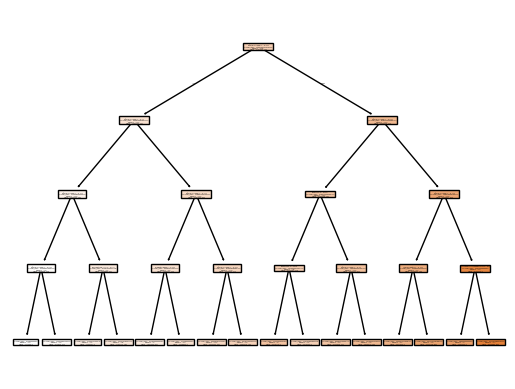

In [20]:

model, regr_score = create_best_model(best_parameters_reg, is_regression=True)
regression_test = regression_test[regression_all]
y_pred = model.predict(regression_test)
submission_reg = pd.DataFrame({'id': ids_reg, 'Цена': y_pred})

submission_reg.to_csv('submission_reg.csv', index=False)
print("Файл submission_reg.csv сохранен.")

tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns))

обрезка дерева

классификация

In [ ]:

dtc = DecisionTreeClassifier(criterion="entropy", max_depth=5)
path = dtc.cost_complexity_pruning_path(x_train_class, y_train_class)
ccp_alphas = path.ccp_alphas
params = {
    "ccp_alpha": path.ccp_alphas
}
best_cpp = test_parameters(params, train_acc, test_acc, cross_val_acc, x_train_class, y_train_class, x_test_class, y_test_class)



Model: DecisionTreeClassifier(ccp_alpha=2.3769082430077394e-05, criterion='entropy',
                       max_depth=10, max_leaf_nodes=38)
Score: 0.898


[Text(0.4895833333333333, 0.9545454545454546, 'Vehicle_Age <= 1.5\nentropy = 1.0\nsamples = 268338\nvalue = [134087, 134251]'),
 Text(0.1736111111111111, 0.8636363636363636, 'Vehicle_Damage <= 0.5\nentropy = 0.619\nsamples = 153768\nvalue = [130165, 23603]'),
 Text(0.05555555555555555, 0.7727272727272727, 'Previously_Insured <= 0.5\nentropy = 0.038\nsamples = 83222\nvalue = [82887, 335]'),
 Text(0.027777777777777776, 0.6818181818181818, 'entropy = 0.23\nsamples = 8307\nvalue = [7996, 311]'),
 Text(0.08333333333333333, 0.6818181818181818, 'entropy = 0.004\nsamples = 74915\nvalue = [74891.0, 24.0]'),
 Text(0.2916666666666667, 0.7727272727272727, 'Age <= 0.115\nentropy = 0.915\nsamples = 70546\nvalue = [47278, 23268]'),
 Text(0.1388888888888889, 0.6818181818181818, 'Policy_Sales_Channel <= 0.923\nentropy = 0.546\nsamples = 14811\nvalue = [12949.0, 1862.0]'),
 Text(0.08333333333333333, 0.5909090909090909, 'Age <= 0.069\nentropy = 0.868\nsamples = 1837\nvalue = [1306, 531]'),
 Text(0.055555

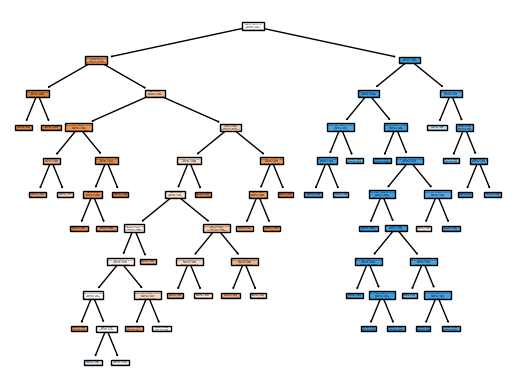

In [ ]:
best_parameters_сlass["ccp_alpha"] = best_cpp
model, score_a_c = create_best_model(best_parameters_сlass)
tree.plot_tree(model, filled=True, feature_names=list(x_train_class.columns))

регрессия

In [ ]:
dtr = DecisionTreeRegressor(max_depth=5)
path = dtr.cost_complexity_pruning_path(x_train_reg, y_train_reg)
params = {
    "ccp_alpha": path.ccp_alphas
}
best_cpp = test_parameters(params, train_acc, test_acc, cross_val_acc, x_train_reg, y_train_reg, x_test_reg, y_test_reg, is_regression=True)

The best model: DecisionTreeRegressor(ccp_alpha=3404583275.7127094)
Accuracy: 0.842


Model: DecisionTreeRegressor(ccp_alpha=3404583275.7127094, max_depth=4,
                      max_leaf_nodes=17)
Score: 0.834


[Text(0.4166666666666667, 0.9, 'Общая.площадь <= 0.361\nsquared_error = 1290199147076.002\nsamples = 565\nvalue = 2751369.731'),
 Text(0.19047619047619047, 0.7, 'Общая.площадь <= 0.21\nsquared_error = 336810582897.862\nsamples = 302\nvalue = 1954483.437'),
 Text(0.09523809523809523, 0.5, 'Общая.площадь <= 0.105\nsquared_error = 174938330099.68\nsamples = 106\nvalue = 1349009.434'),
 Text(0.047619047619047616, 0.3, 'squared_error = 21455547666.009\nsamples = 39\nvalue = 868205.128'),
 Text(0.14285714285714285, 0.3, 'squared_error = 51387926041.435\nsamples = 67\nvalue = 1628880.597'),
 Text(0.2857142857142857, 0.5, 'Общая.площадь <= 0.266\nsquared_error = 118867490130.061\nsamples = 196\nvalue = 2281933.663'),
 Text(0.23809523809523808, 0.3, 'squared_error = 56984917091.836\nsamples = 56\nvalue = 1964107.143'),
 Text(0.3333333333333333, 0.3, 'squared_error = 87052848983.483\nsamples = 140\nvalue = 2409064.271'),
 Text(0.6428571428571429, 0.7, 'Общая.площадь <= 0.542\nsquared_error = 818

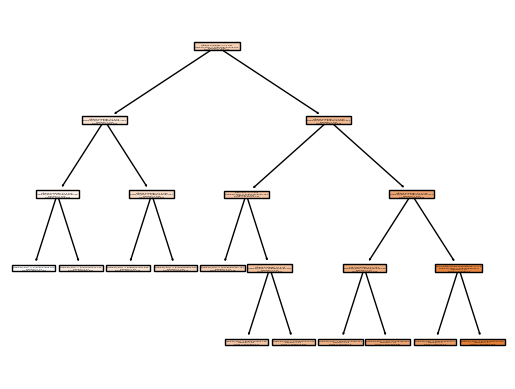

In [ ]:
best_parameters_reg["ccp_alpha"] = best_cpp
model, _ = create_best_model(best_parameters_reg, is_regression=True)
tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns))

видим, что обрезка дерева приводит к увеличению точности и скора

In [ ]:
class_models = pd.DataFrame(
    {
        "Model name": ["Логистическая регрессия", "Метод Ближайших Соседей", "Наивный Байесовский Классификатор", "Линейный Дискриминантный Анализ",
                         "Квадратичный Дискриминантный Анализ", "Машина Опорных Векторов"],
        "Score": [0.811, 0.768, 0.812, 0.812, 0.814, 0.876],
    }
)


In [ ]:
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", "Elastic-Net", "Метод наименьших углов",
                       "Байесовская регрессия", "Обобщённая линейная регрессия", "Взвешенный МНК", "Полиномиальная регрессия",
                       "Непараметрическая регрессия", "Сплайновая регрессия"],
        "R^2": [0.897, 0.898, 0.898, 0.888, 0.897, 0.898, 0.880, 0.878, 0.892, 0.696, 0.880],
    }
)

In [ ]:
class_models.loc[len(class_models.index)] = ["Деревья решений", round(class_score, 3)]
print(class_models)


                            Model name  Score
0              Логистическая регрессия  0.811
1              Метод Ближайших Соседей  0.768
2    Наивный Байесовский Классификатор  0.812
3      Линейный Дискриминантный Анализ  0.812
4  Квадратичный Дискриминантный Анализ  0.814
5              Машина Опорных Векторов  0.876
6                      Деревья решений  0.898


In [ ]:
regression_models.loc[len(regression_models.index)] = ["Деревья решений", round(regr_score, 3)]
print(regression_models)

                       Model name    R^2
0              Линейная регрессия  0.897
1                 Лассо регрессия  0.898
2             Гребневая регрессия  0.898
3                     Elastic-Net  0.888
4          Метод наименьших углов  0.897
5           Байесовская регрессия  0.898
6   Обобщённая линейная регрессия  0.880
7                  Взвешенный МНК  0.878
8        Полиномиальная регрессия  0.892
9     Непараметрическая регрессия  0.696
10           Сплайновая регрессия  0.880
11                Деревья решений  0.844


In [ ]:
def plot_bar_graph(ax, names, scoring, title):
    ax.bar(names, scoring)
    ax.set_title(title)
    ax.tick_params(axis="x", labelrotation=90)  
    ax.set_ylim((0.5, 1))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Модель", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

def compare_models():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_bar_graph(axs[0], regression_models["Model name"], regression_models["R^2"], "Регрессии")
    plot_bar_graph(axs[1], class_models["Model name"], class_models["Score"], "Классификации")


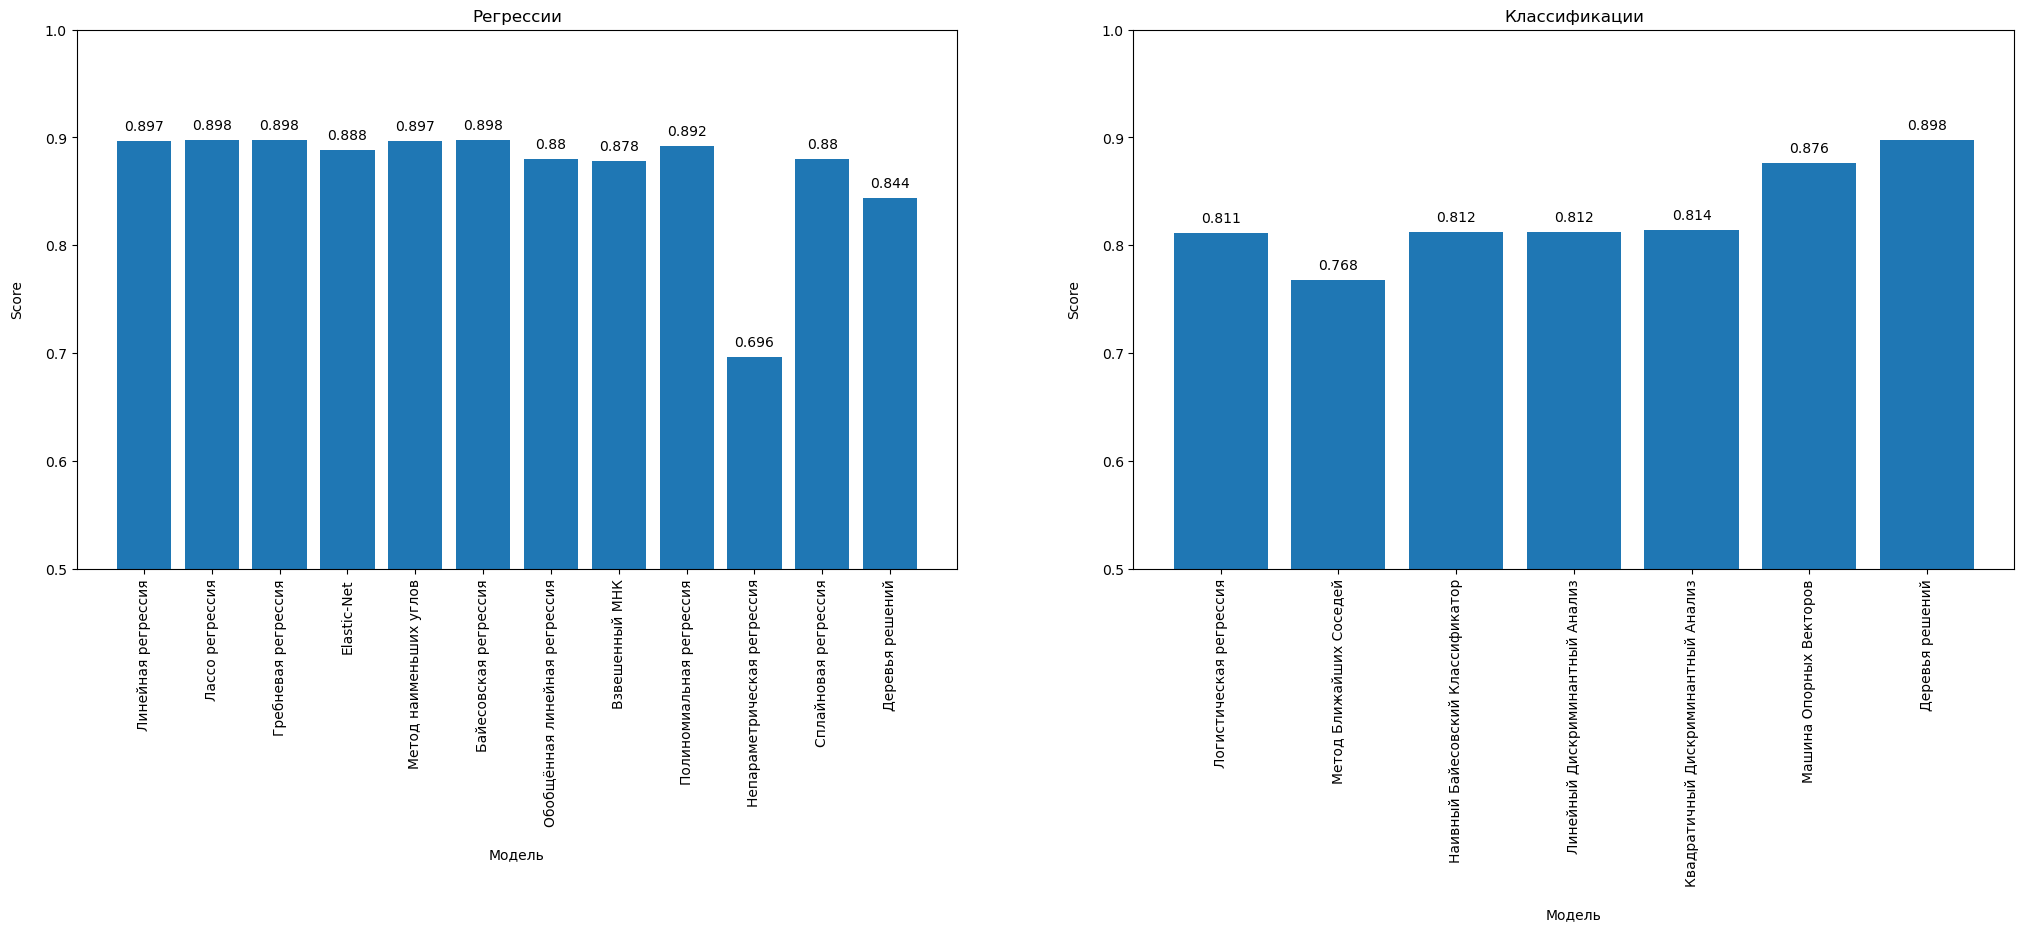

In [ ]:
compare_models()